# Model Comparison and Selection
    Choosing the Right Model Beyond Metrics
## Objective

This notebook provides a structured framework to:

- Compare multiple candidate models

- Evaluate them under realistic constraints

- Select a deployable champion model

It emphasizes:

- Stability

- Interpretability

- Cost-awareness

- Robustness to drift and imbalance

## Why Model Selection Is Hard

Common pitfalls:

- Selecting the highest CV score

- Ignoring operational constraints

- Overfitting to validation data

- Neglecting interpretability and fairness

Best model ≠ Best metric

## Business Context

Applies to:

- Credit risk

- Fraud detection

- Churn modeling

- Pricing and underwriting

- Regulated ML systems

Selection must be defensible and auditable.

## Imports and Dataset

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss
)


In [2]:
df = pd.read_csv("D:/GitHub/Data-Science-Techniques/datasets/Model-evaluation/bank_complaints.csv",
                parse_dates=["application_date"]
).sort_values("application_date")

X = df.drop(columns=["default", "customer_id", "application_date"])
y = df["default"]



df.head()

,customer_id,application_date,age,income,loan_amount,credit_score,utilization,delinquencies,default
0,1,2015-01-01 00:00:00.000000000,44.967142,41744.145757,14243.717707,683.941888,0.283200,0,0
1,2,2015-01-01 03:56:36.229811490,38.617357,40673.393570,29922.058669,708.144874,0.235214,0,0
2,3,2015-01-01 07:53:12.459622981,46.476885,24969.043128,16332.407062,697.055098,0.246711,0,0
3,4,2015-01-01 11:49:48.689434471,55.230299,45790.580761,18869.169625,616.104290,0.241291,1,0
4,5,2015-01-01 15:46:24.919245962,37.658466,20009.589843,25814.594863,670.688985,0.275783,1,0


# MODELS
## Define Candidate Models

In [4]:
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced"
        ))
    ]),
    
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=6,
        class_weight="balanced",
        random_state=2010
    ),
    
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=2010
    )
}


Covers:

- Linear (interpretable)

- Bagging (robust)

- Boosting (high-performance)

## Time-Based Cross-Validation

In [5]:
tscv = TimeSeriesSplit(n_splits=5)


## Evaluation Function

In [6]:
def evaluate_model(model, X, y, cv):
    roc_scores = []
    pr_scores = []
    brier_scores = []
    
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        roc_scores.append(roc_auc_score(y_test, y_prob))
        pr_scores.append(average_precision_score(y_test, y_prob))
        brier_scores.append(brier_score_loss(y_test, y_prob))
    
    return {
        "ROC_AUC_mean": np.mean(roc_scores),
        "PR_AUC_mean": np.mean(pr_scores),
        "Brier_mean": np.mean(brier_scores),
        "ROC_AUC_std": np.std(roc_scores)
    }


## Run Model Comparison

In [7]:
results = []

for name, model in models.items():
    metrics = evaluate_model(model, X, y, tscv)
    metrics["Model"] = name
    results.append(metrics)

results_df = pd.DataFrame(results).set_index("Model")
results_df


,ROC_AUC_mean,PR_AUC_mean,Brier_mean,ROC_AUC_std
Model,,,,
Logistic Regression,0.550207,0.037023,0.294804,0.064662
Random Forest,0.504837,0.035040,0.130503,0.021554
Gradient Boosting,0.524828,0.029539,0.025188,0.020501


## Metric Trade-off Visualization

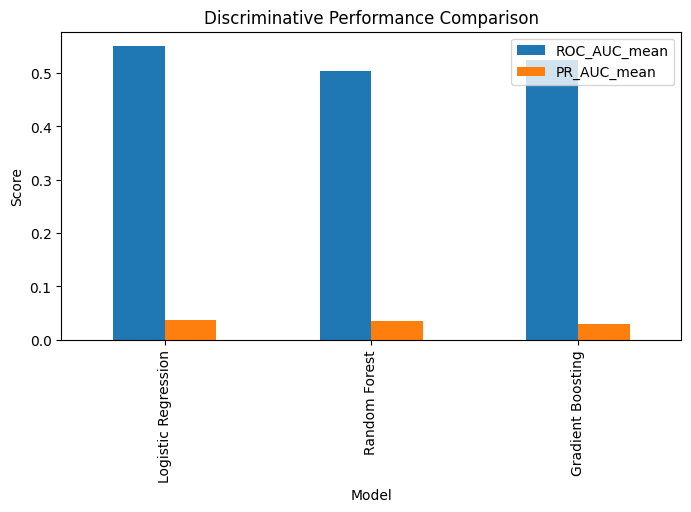

In [8]:
results_df[["ROC_AUC_mean", "PR_AUC_mean"]].plot(
    kind="bar",
    figsize=(8, 4)
)
plt.title("Discriminative Performance Comparison")
plt.ylabel("Score")
plt.show()


## Stability Comparison

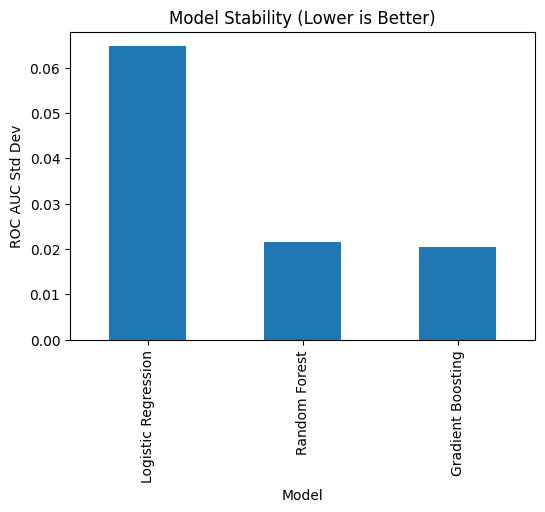

In [9]:
results_df["ROC_AUC_std"].plot(
    kind="bar",
    figsize=(6, 4)
)
plt.title("Model Stability (Lower is Better)")
plt.ylabel("ROC AUC Std Dev")
plt.show()


Stability often matters more than peak performance.

## Calibration Comparison

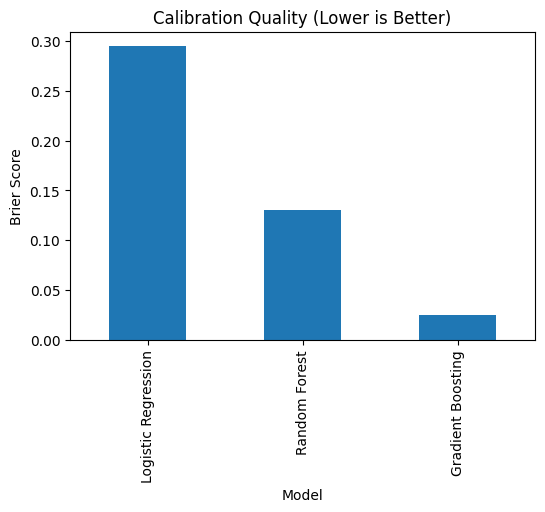

In [10]:
results_df["Brier_mean"].plot(
    kind="bar",
    figsize=(6, 4)
)
plt.title("Calibration Quality (Lower is Better)")
plt.ylabel("Brier Score")
plt.show()


## Decision Matrix

| Criterion        | Logistic | RF   | GB   |
| ---------------- | -------- | ---- | ---- |
| Interpretability | ⭐⭐⭐⭐     | ⭐⭐   | ⭐    |
| Stability        | ⭐⭐⭐      | ⭐⭐⭐⭐ | ⭐⭐   |
| Performance      | ⭐⭐       | ⭐⭐⭐  | ⭐⭐⭐⭐ |
| Calibration      | ⭐⭐⭐⭐     | ⭐⭐   | ⭐⭐   |
| Regulatory Fit   | ⭐⭐⭐⭐     | ⭐⭐   | ⭐    |


## Champion Selection Logic

In [13]:
champion = results_df.sort_values(
    ["PR_AUC_mean", "ROC_AUC_std"],
    ascending=[False, True]
).iloc[0]

champion


ROC_AUC_mean    0.550207
PR_AUC_mean     0.037023
Brier_mean      0.294804
ROC_AUC_std     0.064662
Name: Logistic Regression, dtype: float64

Selection is multi-objective, not single-metric.

## Champion–Challenger Framework

In [14]:
champion_model = models[champion.name]
challenger_models = {
    k: v for k, v in models.items()
    if k != champion.name
}


- ✔ Enables continuous improvement
- ✔ Supports governance requirements

## Common Anti-Patterns

- ❌ Picking the highest ROC only
- ❌ Ignoring variance
- ❌ No baseline model
- ❌ No business alignment
- ❌ No retraining strategy

## Key Takeaways

- Model selection is a decision process

- Stability and calibration matter

- Interpretability is often non-negotiable

- Champion–challenger is best practice

- Metrics must reflect business risk

## Next Notebook

07_Model_Tuning_and_Optimization/

└── [08_threshold_tuning_and_calibration.ipynb](08_threshold_tuning_and_calibration.ipynb)


<br><br><br><br><br>



# Complete: [Data Science Techniques](https://github.com/lei-soares/Data-Science-Techniques)

- [00_Data_Generation_and_Simulation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/00_Data_Generation_and_Simulation)


- [01_Exploratory_Data_Analysis_(EDA)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/01_Exploratory_Data_Analysis_(EDA))


- [02_Data_Preprocessing](https://github.com/lei-soares/Data-Science-Techniques/tree/main/02_Data_Preprocessing)


- [03_Feature_Engineering](https://github.com/lei-soares/Data-Science-Techniques/tree/main/03_Feature_Engineering)


- [04_Supervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/04_Supervised_Learning)

    - [Regression Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/01_regression_models)
    
    - [Classification Models](https://github.com/lei-soares/Data-Science-Techniques/tree/49de369e0600a513b54445e8cb4196b26ce71853/04_Supervised_Learning/02_classification_models)


- [05_Unsupervised_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/05_Unsupervised_Learning)


- [06_Model_Evaluation_and_Validation](https://github.com/lei-soares/Data-Science-Techniques/tree/main/06_Model_Evaluation_and_Validation)


- [07_Model_Tuning_and_Optimization](https://github.com/lei-soares/Data-Science-Techniques/tree/main/07_Model_Tuning_and_Optimization)


- [08_Interpretability_and_Explainability](https://github.com/lei-soares/Data-Science-Techniques/tree/main/08_Interpretability_and_Explainability)


- [09_Pipelines_and_Workflows](https://github.com/lei-soares/Data-Science-Techniques/tree/main/09_Pipelines_and_Workflows)


- [10_Natural_Language_Processing_(NLP)](https://github.com/lei-soares/Data-Science-Techniques/tree/main/10_Natural_Language_Processing_(NLP))


- [11_Time_Series](https://github.com/lei-soares/Data-Science-Techniques/tree/main/11_Time_Series)


- [12_Anomaly_and_Fraud_Detection](https://github.com/lei-soares/Data-Science-Techniques/tree/main/12_Anomaly_and_Fraud_Detection)


- [13_Imbalanced_Learning](https://github.com/lei-soares/Data-Science-Techniques/tree/main/13_Imbalanced_Learning)


- [14_Deployment_and_Production_Concepts](https://github.com/lei-soares/Data-Science-Techniques/tree/main/14_Deployment_and_Production_Concepts)


- [15_Business_and_Experimental_Design](https://github.com/lei-soares/Data-Science-Techniques/tree/main/15_Business_and_Experimental_Design)




<br><br><br><br><br>

[Panfugo Dados](www.pantufodados.com)


[Pantufo Dados - YouTube Channel](https://www.youtube.com/@pantufodados)